In [1]:
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 292 kB 22.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Weights and Bias to version the dataset and experiment tracking
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 1.8 MB 21.7 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 27.3 MB/s eta 0:00:01
     |████████████████████████████████| 145 kB 28.8 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 48.2 MB/s eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=2a816173df6af6236bc10211180c8b9e3c7be620d961f140342cd58f4d8ab2c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-b9mr6xt5/wheels/54/aa/01/724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=9eecc6100fdd3557dcd14e97e6610663fe48ec9b290bb59b46b3c1702f445937
  Stored in directory: /tmp/pip-ephem-wheel-cache-b9mr6xt5/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built promise pathtools


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
import warnings
warnings.filterwarnings("ignore")

In [5]:
import json
import random

In [7]:
!pip install more-itertools

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 51 kB 14.0 MB/s eta 0:00:01


In [8]:
import collections
import itertools
from collections import Counter
from more_itertools import take

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam

from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support

In [9]:
SEED = 1234

In [10]:
def set_seeds(seed=1234):
    """set seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # For multi-gpu

In [11]:
set_seeds(SEED)

In [12]:
cuda = True
device = torch.device("cuda" if(
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")

if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

print(device)

cuda


In [13]:
train_df = pd.read_parquet("../../dataset/v1.0/train/train.parquet")
val_df = pd.read_parquet("../../dataset/v1.0/val/val.parquet")
test_df = pd.read_parquet("../../dataset/v1.0/test/test.parquet")

In [14]:
train_df.head()

,transcription,specialty
0,indications 55 year old female colonoscopy scr...,surgery
1,axial back pain greatly improved completely er...,consult history phy
2,preoperative diagnoses epiretinal membrane rig...,ophthalmology
3,preoperative diagnosis squamous cell carcinoma...,surgery
4,exam ultrasound guided paracentesis history as...,surgery


[1480, 1292, 1239, 1239, 1139, 1139, 1139, 1136, 1136, 1100]


<AxesSubplot:ylabel='count'>

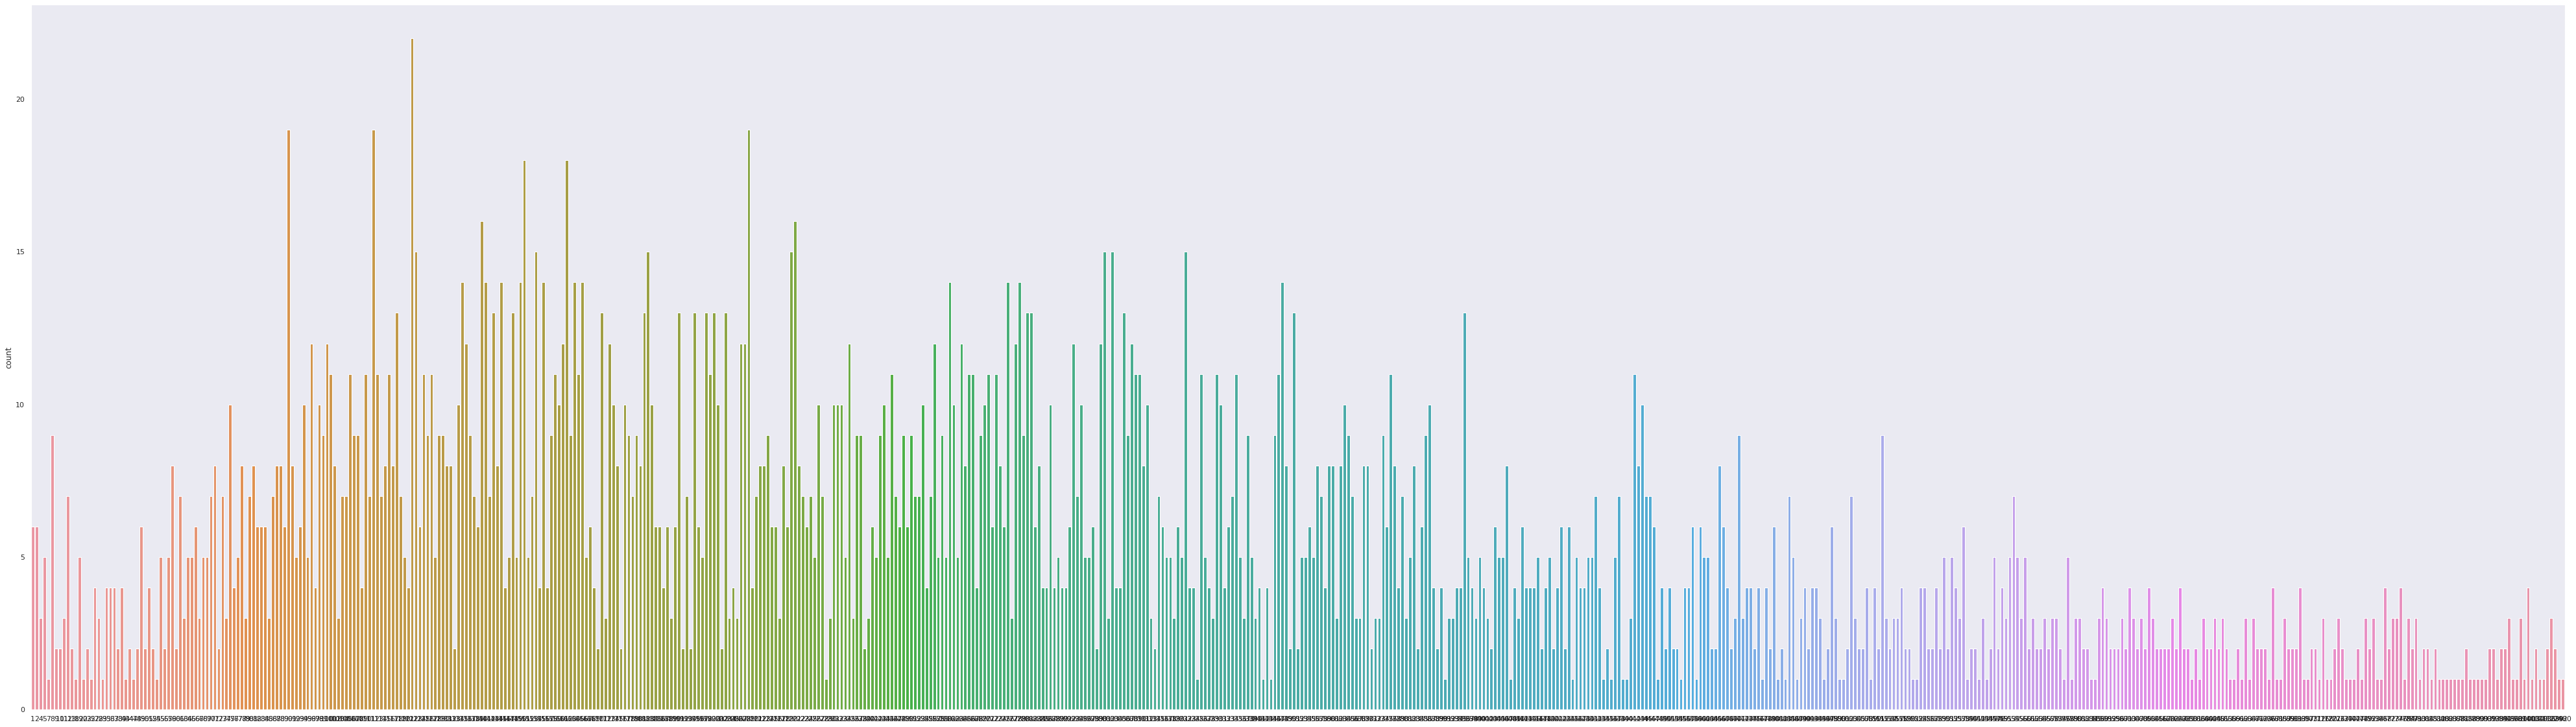

In [136]:
# Sentence length distribution
sent_lengths = sorted([len(sent.split(' ')) for sent in train_df['transcription'].values], reverse=True)
print(sent_lengths[:10])
plt.figure(figsize=(70,20))
sns.countplot(sent_lengths)

In [137]:
sent_counter = Counter(sent_lengths).most_common(1000)
sent_counter

[(122, 22),
 (209, 19),
 (112, 19),
 (90, 19),
 (162, 18),
 (151, 18),
 (221, 16),
 (140, 16),
 (322, 15),
 (303, 15),
 (301, 15),
 (220, 15),
 (183, 15),
 (154, 15),
 (123, 15),
 (348, 14),
 (279, 14),
 (276, 14),
 (261, 14),
 (166, 14),
 (164, 14),
 (156, 14),
 (150, 14),
 (145, 14),
 (141, 14),
 (135, 14),
 (396, 13),
 (351, 13),
 (306, 13),
 (282, 13),
 (281, 13),
 (203, 13),
 (200, 13),
 (198, 13),
 (195, 13),
 (191, 13),
 (182, 13),
 (171, 13),
 (148, 13),
 (143, 13),
 (118, 13),
 (308, 12),
 (300, 12),
 (293, 12),
 (278, 12),
 (264, 12),
 (257, 12),
 (235, 12),
 (208, 12),
 (207, 12),
 (173, 12),
 (161, 12),
 (136, 12),
 (100, 12),
 (96, 12),
 (442, 11),
 (376, 11),
 (347, 11),
 (335, 11),
 (330, 11),
 (326, 11),
 (310, 11),
 (309, 11),
 (273, 11),
 (271, 11),
 (267, 11),
 (266, 11),
 (246, 11),
 (199, 11),
 (165, 11),
 (159, 11),
 (127, 11),
 (125, 11),
 (116, 11),
 (113, 11),
 (110, 11),
 (106, 11),
 (101, 11),
 (444, 10),
 (387, 10),
 (364, 10),
 (331, 10),
 (312, 10),
 (295,

In [81]:
# Feature and target
X_train = train_df.transcription.values
y_train = train_df.specialty

X_val =  val_df.transcription.values
y_val = val_df.specialty

X_test = test_df.transcription.values
y_test = test_df.specialty

In [82]:
print(f"X_train: {X_train.shape}, y_train:{y_train.shape}")
print(f"X_train: {X_val.shape}, y_train:{y_val.shape}")
print(f"X_train: {X_test.shape}, y_train:{y_test.shape}")

X_train: (3476,), y_train:(3476,)
X_train: (745,), y_train:(745,)
X_train: (745,), y_train:(745,)


In [83]:
print(f"Sample: {X_train[0]} -> {y_train[0]}")

Sample: indications 55 year old female colonoscopy screen colon cancer family history colon cancer blood stool procedure performed colonoscopy prep fentanyl 100 mcg iv 3 mg versed iv procedure tip endoscope introduced rectum retroflexion tip endoscope failed reveal distal rectal lesions rest colon cecum well visualized cecal strap ileocecal valve light reflex right lower quadrant identified evidence tumor polyp mass ulceration focus inflammation adverse reactions none impression normal colonic mucosa cecum evidence tumor polyp -> surgery


In [84]:
# Label encoder to encode class labels
class LabelEncoder(object):
    """Encode labels into unqiue ids/integers"""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        
    def __len__(self):
        return len(self.class_to_index)
    
    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"
    
    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self
    
    def encode(self, y):
        encoded = np.zeros(len(y), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded
    
    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
            
        return classes
    
    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)
    
    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [85]:
label_encoder = LabelEncoder.load("../../data_artifacts/label_encoder.json")

In [86]:
# Encode all our labels
y_train = label_encoder.encode(y_train)

y_val = label_encoder.encode(y_val)

y_test = label_encoder.encode(y_test)

In [87]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print(f"counts: {counts}\n weights: {class_weights}")

counts: [  5   6  13 260  10 361  19  19  20   7  76  52  13  67 157 181  63   4
  11   6  16  57 156  66 108  35  58 248  43  49  15  33  37 191   7  14
 116   6 762 109]
 weights: {0: 0.2, 1: 0.16666666666666666, 2: 0.07692307692307693, 3: 0.0038461538461538464, 4: 0.1, 5: 0.002770083102493075, 6: 0.05263157894736842, 7: 0.05263157894736842, 8: 0.05, 9: 0.14285714285714285, 10: 0.013157894736842105, 11: 0.019230769230769232, 12: 0.07692307692307693, 13: 0.014925373134328358, 14: 0.006369426751592357, 15: 0.0055248618784530384, 16: 0.015873015873015872, 17: 0.25, 18: 0.09090909090909091, 19: 0.16666666666666666, 20: 0.0625, 21: 0.017543859649122806, 22: 0.00641025641025641, 23: 0.015151515151515152, 24: 0.009259259259259259, 25: 0.02857142857142857, 26: 0.017241379310344827, 27: 0.004032258064516129, 28: 0.023255813953488372, 29: 0.02040816326530612, 30: 0.06666666666666667, 31: 0.030303030303030304, 32: 0.02702702702702703, 33: 0.005235602094240838, 34: 0.14285714285714285, 35: 0.071

In [88]:
# Tokenizer
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None, pad_token="<PAD>",
                oov_token="<UNK", token_to_index=None):
        self.char_level = char_level
        self.separator = "" if self.char_level else " "
        if num_tokens: num_tokens -=2 # pad token and unk token excluded
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v:k for k, v in self.token_to_index.items()}
        
    def __len__(self):
        return len(self.token_to_index)
    
    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"
    
    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(' ') for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(" ")
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]
                ))
            sequences.append(sequence)
        return sequences
            
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(
                    index, self.oov_token
                ))
            texts.append(self.separator.join([token for token in text]))
        return texts
    
    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
    
    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [89]:
# Check the full vocabulary size of training data
def check_vocab_size(texts):
    texts = [text.split(' ') for text in texts]
    all_tokens = [token for text in texts for token in text]
    # print(len(all_tokens))
    vocab_counts = Counter(all_tokens).most_common(None)
    # print(vocab_counts)
    print(f"Total vocabulary size is: {len(vocab_counts)}")

In [90]:
check_vocab_size(X_train)

Total vocabulary size is: 24547


In [91]:
tokenizer = Tokenizer(char_level=False, num_tokens=1000)
tokenizer.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokenizer)
print(tokenizer)

<Tokenizer(num_tokens=1000)>


In [92]:
# Sample
print(take(15, tokenizer.token_to_index.items()))
print(f"Least frequent token's frequency: {tokenizer.min_token_freq}")

[('<PAD>', 0), ('<UNK', 1), ('patient', 2), ('right', 3), ('left', 4), ('history', 5), ('2', 6), ('1', 7), ('normal', 8), ('procedure', 9), ('placed', 10), ('0', 11), ('3', 12), ('well', 13), ('pain', 14)]
Least frequent token's frequency: 203


In [93]:
tokenizer.save(Path("../../data_artifacts/tokenizer.json"))

In [94]:
# convert texts to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print("Text to indices: \n"
     f" (Preprocessed) -> {preprocessed_text}\n"
     f" (Tokenized) -> {X_train[0]}")

Text to indices: 
 (Preprocessed) -> indications <UNK year old female colonoscopy <UNK colon cancer family history colon cancer blood <UNK procedure performed colonoscopy <UNK <UNK 100 <UNK iv 3 mg <UNK iv procedure tip <UNK introduced <UNK <UNK tip <UNK <UNK <UNK distal rectal lesions rest colon <UNK well visualized <UNK <UNK <UNK valve light <UNK right lower quadrant identified evidence tumor <UNK mass <UNK <UNK <UNK <UNK <UNK none impression normal <UNK mucosa <UNK evidence tumor <UNK
 (Tokenized) -> [341, 1, 31, 32, 138, 945, 1, 411, 276, 112, 5, 411, 276, 20, 1, 9, 21, 945, 1, 1, 356, 1, 168, 12, 23, 1, 168, 9, 629, 1, 957, 1, 1, 629, 1, 1, 1, 104, 666, 254, 525, 411, 1, 13, 422, 1, 1, 1, 448, 436, 1, 3, 49, 589, 115, 82, 264, 1, 147, 1, 1, 1, 1, 1, 106, 212, 8, 1, 511, 1, 82, 264, 1]


In [95]:
def to_categorical(seq, num_classes):
    """One-hot encode sequence of tokens"""
    one_hot = np.zeros((len(seq), num_classes))
    for i, item in enumerate(seq):
        one_hot[i, item] = 1
    return one_hot

In [96]:
print(X_train[0])
print(len(X_train[0]))
cat = to_categorical(seq=X_train[0], num_classes=len(tokenizer))
print(cat)
print(cat.shape)

[341, 1, 31, 32, 138, 945, 1, 411, 276, 112, 5, 411, 276, 20, 1, 9, 21, 945, 1, 1, 356, 1, 168, 12, 23, 1, 168, 9, 629, 1, 957, 1, 1, 629, 1, 1, 1, 104, 666, 254, 525, 411, 1, 13, 422, 1, 1, 1, 448, 436, 1, 3, 49, 589, 115, 82, 264, 1, 147, 1, 1, 1, 1, 1, 106, 212, 8, 1, 511, 1, 82, 264, 1]
73
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(73, 1000)


In [98]:
vocab_size = len(tokenizer)
X_train = [to_categorical(seq=seq, num_classes=vocab_size) for seq in X_train]
X_val = [to_categorical(seq=seq, num_classes=vocab_size) for seq in X_val]
X_test = [to_categorical(seq=seq, num_classes=vocab_size) for seq in X_test]

In [99]:
# Pad the sequences to max_length
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max_length in sequence"""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    num_classes = sequences[0].shape[-1]
    padded_sequences = np.zeros((len(sequences), max_seq_len, num_classes))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [100]:
print(X_train[0].shape, X_train[1].shape, X_train[2].shape)
padded = pad_sequences(X_train[0:3])
print(padded.shape)

(73, 1000) (169, 1000) (126, 1000)
(3, 169, 1000)


In [103]:
FILTER_SIZE = 1 # Unigram, we can try bigram and trigram as well

In [113]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size
        
    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]
    
    def collate_fn(self, batch):
        batch = np.array(batch)
        X = batch[:, 0]
        y = batch[:, 1]
        
        X = pad_sequences(X, max_seq_len=self.max_filter_size)
        
        X = torch.FloatTensor(X.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))
        
        return X, y
    
    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True
        )

In [114]:
train_dataset = Dataset(X=X_train, y=y_train, max_filter_size=FILTER_SIZE)
val_dataset = Dataset(X=X_val, y=y_val, max_filter_size=FILTER_SIZE)
test_dataset = Dataset(X=X_test, y=y_test, max_filter_size=FILTER_SIZE)

In [117]:
print("Dasets: \n"
     f"Train Dataset: {train_dataset.__str__()}\n"
     f"Val Dataset: {val_dataset.__str__()}\n"
     f"Test Dataset: {test_dataset.__str__()}\n"
     f"Sample Data:\n"
     f"X: {train_dataset[0][0]}\n"
     f"y {train_dataset[0][1]}")

Dasets: 
Train Dataset: <Dataset(N=3476)>
Val Dataset: <Dataset(N=745)>
Test Dataset: <Dataset(N=745)>
Sample Data:
X: [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
y 38


In [116]:
batch_size = 128
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)

In [118]:
batch_X, batch_y = next(iter(train_dataloader))
print("Sample batch:\n"
     f"X: {list(batch_X.size())}\n"
     f"y: {list(batch_y.size())}\n"
     f"Sample point: \n"
     f"X: {batch_X[0]}\n"
     f"y: {batch_y[0]}")

Sample batch:
X: [128, 1049, 1000]
y: [128]
Sample point: 
X: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cpu')
y: 38


In [141]:
NUM_FILTERS = 50
HIDDEN_DIM = 100
DROPOUT_P = 0.1
NUM_CLASSES = len(label_encoder)

In [142]:
NUM_CLASSES

40

In [139]:
class CNN(nn.Module):
    def __init__(self, vocab_size, num_filters, filter_size,
                hidden_dim, dropout, num_classes):
        super(CNN, self).__init__()
        
        self.filter_size = filter_size
        self.conv = nn.Conv1d(
            in_channels=vocab_size, out_channels=num_filters,
            kernel_size=filter_size, stride=1, padding=0, padding_mode="zeros"
        )
        self.batch_norm = nn.BatchNorm1d(num_features=num_filters)
        
        self.fc1 = nn.Linear(num_filters, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, inputs, channel_first=False):
        x_in, = inputs
        if not channel_first:
            x_in = x_in.transpose(1, 2)
        
        # "SAME" padding
        max_seq_len = x_in.shape[2]
        padding_left = int((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2)
        padding_right = int(math.ceil((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2))
        
        z = self.conv(F.pad(x_in, (padding_left, padding_right)))
        z = F.max_pool1d(z, z.size(2)).squeeze(2)
        
        
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)
        
        return z

In [144]:
model = CNN(vocab_size=VOCAB_SIZE, num_filters=NUM_FILTERS, filter_size=FILTER_SIZE,
            hidden_dim=HIDDEN_DIM, dropout=DROPOUT_P, num_classes=NUM_CLASSES)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (conv): Conv1d(1000, 50, kernel_size=(1,), stride=(1,))
  (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=40, bias=True)
)>


In [145]:
LEARNING_RATE = 1e-3
PATIENCE = 5
NUM_EPOCHS = 20

In [177]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    def train_step(self, dataloader):
        self.model.train()
        loss = 0.0
        
        # iterate over batches
        for i, batch in enumerate(dataloader):
            batch = [item.to(device) for item in batch]
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()
            z = self.model(inputs)
            J = self.loss_fn(z, targets)
            J.backward()
            self.optimizer.step()
            
            loss += (J.detach().item() - loss) / (i+1)
        return loss
    
    def eval_step(self, dataloader):
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []
        
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):
                batch = [item.to(device) for item in batch]
                inputs, y_true = batch[:-1], batch[-1]
                
                z = self.model(inputs)
                J = self.loss_fn(z, y_true).item()
                
                loss += (J - loss) / (i + 1)
                
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())
                
            
            return loss, np.vstack(y_trues), np.vstack(y_probs)
        
    def predict_step(self, dataloader):
        self.model.eval()
        y_probs = []
        
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):
                inputs, targets = batch[:-1], batch[-1]
                
                z = self.model(inputs)
                
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
            return np.vstack(y_probs)
    
    def train(self, num_epochs, patience, train_dataloder, val_dataloader, wandb_run):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                wandb_run.summary["Best val loss"] = best_val_loss
                _patience = patience
            else:
                _patience -= 1
            
            if not _patience:
                print("Stopping Early")
                break
            
            wandb.log({"train_loss": train_loss})
            wandb.log({"val_loss": val_loss})
            
            print(
                f"Epoch: {epoch+1}\n"
                f"\t train_loss: {train_loss:.3f}, "
                f"\t val_loss: {val_loss: .3f}, "
                f"\t LR: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

In [178]:
# loss function
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [179]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3
)

In [180]:
CONFIG = dict(
    learning_rate=LEARNING_RATE,
    patience=PATIENCE,
    epochs=NUM_EPOCHS,
    target_classes=NUM_CLASSES,
    optimizer="Adam",
    scheduler="ReduceLROnPlateau",
    loss_function="Cross Entropy",
    model="CNN",
)

In [155]:
import wandb

In [156]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [157]:
run = wandb.init(project="Medical-Transcription", config=CONFIG, name="CNN")

wandb: Currently logged in as: alokpadhi. Use `wandb login --relogin` to force relogin


In [181]:
trainer = Trainer(model=model, device=device, loss_fn=loss_fn,
                 optimizer=optimizer, scheduler=scheduler)

In [182]:
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader, run
)

Epoch: 1
	 train_loss: 3.669, 	 val_loss:  3.668, 	 LR: 1.00E-03, _patience: 5
Epoch: 2
	 train_loss: 3.641, 	 val_loss:  3.642, 	 LR: 1.00E-03, _patience: 5
Epoch: 3
	 train_loss: 3.590, 	 val_loss:  3.582, 	 LR: 1.00E-03, _patience: 5
Epoch: 4
	 train_loss: 3.488, 	 val_loss:  3.471, 	 LR: 1.00E-03, _patience: 5
Epoch: 5
	 train_loss: 3.342, 	 val_loss:  3.342, 	 LR: 1.00E-03, _patience: 5
Epoch: 6
	 train_loss: 3.191, 	 val_loss:  3.229, 	 LR: 1.00E-03, _patience: 5
Epoch: 7
	 train_loss: 3.052, 	 val_loss:  3.123, 	 LR: 1.00E-03, _patience: 5
Epoch: 8
	 train_loss: 2.909, 	 val_loss:  3.019, 	 LR: 1.00E-03, _patience: 5
Epoch: 9
	 train_loss: 2.770, 	 val_loss:  2.920, 	 LR: 1.00E-03, _patience: 5
Epoch: 10
	 train_loss: 2.627, 	 val_loss:  2.824, 	 LR: 1.00E-03, _patience: 5
Epoch: 11
	 train_loss: 2.492, 	 val_loss:  2.736, 	 LR: 1.00E-03, _patience: 5
Epoch: 12
	 train_loss: 2.365, 	 val_loss:  2.661, 	 LR: 1.00E-03, _patience: 5
Epoch: 13
	 train_loss: 2.236, 	 val_loss:  2.593

In [183]:
def get_metrics(y_true, y_pred, classes):
    performance = {"overall": {}, "class": {}}
    
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1-score"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))
    
    # Per-class performance
    class_metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": class_metrics[0][i],
            "recall": class_metrics[1][i],
            "f1-score": class_metrics[2][i],
            "num_samples": np.float64(class_metrics[3][i]),
        }
        
    return performance

In [184]:
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

In [185]:
performance = get_metrics(y_true, y_pred, classes=label_encoder.classes)
print(json.dumps(performance["overall"], indent=2))

{
  "precision": 0.3346409610660521,
  "recall": 0.28859060402684567,
  "f1-score": 0.2695977535816174,
  "num_samples": 745.0
}


In [186]:
run.log({"precision": performance["overall"]["precision"], "recall": performance["overall"]["recall"], "f1-score": performance["overall"]["f1-score"]})